In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
#import visuals as vs
#from lime import lime_tabular
#import shap

from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

random_state = 6
np.random.seed(random_state)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
## look data with pandas
train_file = "/content/rupturemodel_train.txt"
val_file = "/content/rupturemodel_validate.txt"
test_file = "/content/rupturemodel_test.txt"


df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

columns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = columns
df_val.columns = columns
df_test.columns = columns

frames = [df_train, df_val]
df_train = pd.concat(frames)
print('train data shape {} and test data shape {}'.format(np.shape(df_train), np.shape(df_test)))

NameError: ignored

In [ ]:
df_train.head(5)

,height,width,sxx,sxy,syy,sdrop,mud,dc,label
0,0.103861,1.145663,-102.509086,58.619371,-117.766562,0.483821,0.216681,0.295842,0.0
1,0.088714,1.304360,-136.062270,51.391037,-126.715571,0.345944,0.447964,0.406466,1.0
2,0.099706,1.260377,-117.558936,40.972081,-115.529343,0.292719,0.501697,0.389360,1.0
3,0.115749,1.191782,-128.169036,94.020712,-157.830504,0.571710,0.202831,0.408976,0.0
4,0.017900,1.108150,-106.350320,29.148969,-101.379323,0.253122,0.324653,0.398592,1.0


In [ ]:
mms = StandardScaler()
xtrain = mms.fit_transform(df_train.drop('label', axis=1))
ytrain = df_train['label'].values
xtest = mms.fit_transform(df_test.drop('label', axis=1))
ytest = df_test['label'].values

In [ ]:
#import ace

ModuleNotFoundError: ignored

In [ ]:
np.mean(ytrain)

0.349375

In [ ]:
xtransfer = np.transpose(np.array(df_train.drop('label', axis=1)))
ytransfer = list(df_train.label.values)
xtransfer

array([[ 1.03861000e-01,  8.87140000e-02,  9.97060000e-02, ...,
         2.45450000e-02,  1.35133000e-01,  9.90780000e-02],
       [ 1.14566300e+00,  1.30436000e+00,  1.26037700e+00, ...,
         2.00795800e+00,  1.88491900e+00,  1.83929100e+00],
       [-1.02509086e+02, -1.36062270e+02, -1.17558936e+02, ...,
        -7.07691400e+01, -2.12003590e+01, -7.98741440e+01],
       ...,
       [ 4.83821000e-01,  3.45944000e-01,  2.92719000e-01, ...,
         2.72537000e-01,  3.48628000e-01,  2.93341000e-01],
       [ 2.16681000e-01,  4.47964000e-01,  5.01697000e-01, ...,
         4.33502000e-01,  3.08436000e-01,  3.08371000e-01],
       [ 2.95842000e-01,  4.06466000e-01,  3.89360000e-01, ...,
         3.91503000e-01,  3.83268000e-01,  3.63256000e-01]])

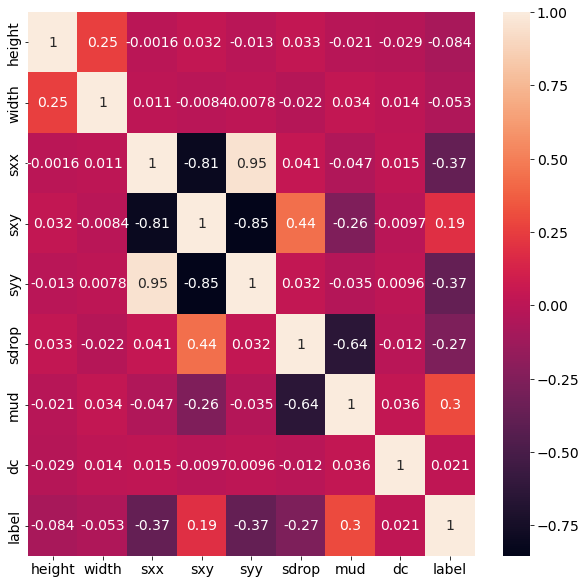

In [ ]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
sns.heatmap(df_train.corr(), annot = True)
plt.savefig('corr_heat_map.eps')

In [ ]:
label_count = df_train.groupby('label', as_index = False).count()
class_name = ['Rupture arrest', 'Rupture propagate']
count = list(label_count['height'])
print('Rupture propagate : {}, \nRupture arrest: {}'.format(count[0], count[1]))
print('Total number of data: {}'.format(np.sum(count)))
print('Class ratio for rupture propagation: {}'.format(count[0]/count[1]))

Rupture propagate : 1041, 
Rupture arrest: 559
Total number of data: 1600
Class ratio for rupture propagation: 1.8622540250447228


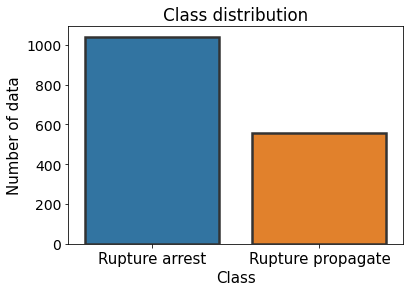

In [ ]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x = class_name, y = count, linewidth = 2.5, errcolor = ".2", edgecolor = ".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

In [ ]:
POS_CLASS_RATIO = count[0]/count[1]

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(ytrain),
                                        y = ytrain                                                  
                                    )
class_weights = dict(zip(np.unique(ytrain), class_weights))
class_weights

{0.0: 0.7684918347742555, 1.0: 1.4311270125223614}

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
rfc = RandomForestClassifier(criterion='entropy', random_state = random_state, class_weight='balanced')
params = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [3, 4, 5, 7, 10],
    'min_samples_split': [40, 50, 60, 70]
}

grid_clf = GridSearchCV(estimator = rfc, param_grid = params, scoring = 'accuracy', cv = cv)

# we have to find out best optimized parameters
grid_clf.fit(xtrain, ytrain.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              random_state=6),
             param_grid={'max_depth': [3, 4, 5, 7, 10],
                         'min_samples_split': [40, 50, 60, 70],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='accuracy')

In [ ]:
# get the best model
print('\n # Best estimator ---------\n{}'.format(grid_clf.best_estimator_))

# Get the best parameters
print('\n # Best parameters ---------\n{}'.format(grid_clf.best_params_))

# best score
print('\n # Best score ---------\n{}'.format(grid_clf.best_score_))


 # Best estimator ---------
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_split=40, n_estimators=50,
                       random_state=6)

 # Best parameters ---------
{'max_depth': 7, 'min_samples_split': 40, 'n_estimators': 50}

 # Best score ---------
0.7449999999999999


In [ ]:
ypred = grid_clf.predict(xtest)

In [ ]:
print('The accuracy of the model is {}'.format(accuracy_score(ytest, ypred)))
print('# Classification report \n {}'.format(classification_report(ytest, ypred)))

The accuracy of the model is 0.805
# Classification report 
               precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       272
         1.0       0.65      0.83      0.73       128

    accuracy                           0.81       400
   macro avg       0.78      0.81      0.79       400
weighted avg       0.83      0.81      0.81       400



In [ ]:
confusion_matrix(ypred, ytest)

array([[216,  22],
       [ 56, 106]])

In [ ]:
model = RandomForestClassifier(bootstrap=True, class_weight = 'balanced',
            criterion='entropy', max_depth=5, max_features = 'auto',
            max_leaf_nodes=None, min_impurity_decrease = 1e-07,
            min_samples_leaf=1, min_samples_split = 10,
            min_weight_fraction_leaf = 0.0, n_estimators = 20, n_jobs=1,
            oob_score=False, random_state = random_state)

model.fit(xtrain, ytrain.astype(int))
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

length = len(list(df_train))
features= list(df_train)[:length-1]

# Print the feature ranking
print("Feature ranking:")

features_rank =[]
label_name = []
for f in range(xtrain.shape[1]):
    features_rank.append(importances[indices[f]])
    label_name.append(features[indices[f]])
    print("{}. Feature {} ({}%)".format(f + 1, features[indices[f]], round(importances[indices[f]]*100, 2)))

Feature ranking:
1. Feature sxx (22.61%)
2. Feature mud (19.12%)
3. Feature syy (15.28%)
4. Feature sdrop (14.62%)
5. Feature sxy (13.9%)
6. Feature height (5.73%)
7. Feature dc (4.42%)
8. Feature width (4.33%)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be

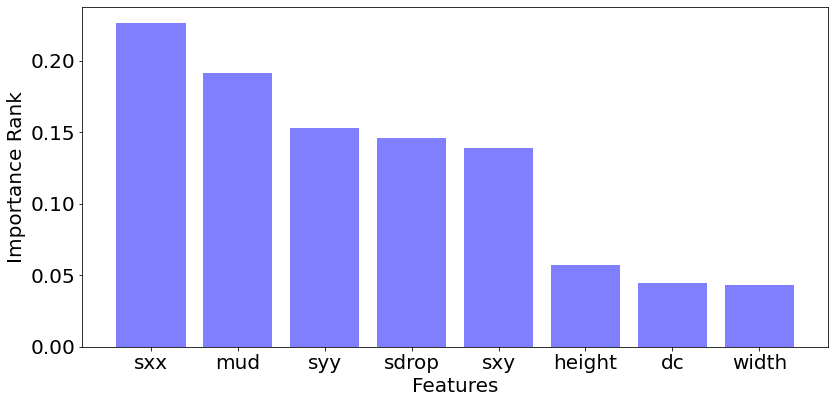

In [ ]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 20}

plt.rc('font', **font)

y_pos = np.arange(len(features_rank))
performance = features_rank

plt.figure(figsize=(12, 6))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='b')
plt.xticks(y_pos, label_name)
plt.ylabel('Importance Rank')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('rf_important_features.eps')

In [ ]:
import pickle
file = open('rupture_random_forest.pkl', 'wb')
pickle.dump(grid_clf, file)
file.close()

In [ ]:
file = open('rupture_random_forest.pkl', 'rb')
model = pickle.load(file)

In [ ]:
ypred = model.predict(xtest)
print('The accuracy of the model is {}'.format(accuracy_score(ytest, ypred)))
print('# Classification report \n {}'.format(classification_report(ytest, ypred)))

The accuracy of the model is 0.805
# Classification report 
               precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       272
         1.0       0.65      0.83      0.73       128

    accuracy                           0.81       400
   macro avg       0.78      0.81      0.79       400
weighted avg       0.83      0.81      0.81       400

